<a href="https://colab.research.google.com/github/AnasNedday/RecommandationBasedUsers/blob/main/RecommandationSystemBasedUsersRatings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
import pandas as pd
import numpy as np

### Chargement des données


In [2]:
df_movies = pd.read_csv('../movies.csv')
df_ratings = pd.read_csv('../ratings.csv')

In [3]:
df_movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
df_ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [ ]:
# from sklearn.metrics.pairwise import cosine_similarity
# from sklearn.feature_extraction.text import CountVectorizer

# class ContentBasedRecommender:
#     def __init__(self, path_movies, path_ratings):
#         """
#         Initialisation du modèle de recommandation basé sur le contenu.

#         :param path_movies: chemin vers le fichier contenant les informations des films
#         :param path_ratings: chemin vers le fichier contenant les évaluations des utilisateurs
#         """
#         self.path_movies = path_movies
#         self.path_ratings = path_ratings
#         self.movies_df = None
#         self.user_ratings_df = None

#     def _prep_data(self):
#         """
#         Préparer les données pour le système de recommandation.
#         """
#         # Charger les données des films et des évaluations
#         self.movies_df = pd.read_csv(self.path_movies, usecols=['movieId', 'title', 'genres'])
#         self.user_ratings_df = pd.read_csv(self.path_ratings, usecols=['userId', 'movieId', 'rating'])

#         # Combiner les genres en une seule chaîne par film
#         self.movies_df['genres'] = self.movies_df['genres'].fillna('')
#         return self.movies_df

#     def _compute_similarity_matrix(self):
#         """
#         Calculer la matrice de similarité cosinus basée sur les genres des films.
#         """
#         count_vectorizer = CountVectorizer(tokenizer=lambda x: x.split('|'))
#         genre_matrix = count_vectorizer.fit_transform(self.movies_df['genres'])

#         # Calculer la similarité cosinus
#         similarity_matrix = cosine_similarity(genre_matrix, genre_matrix)
#         return similarity_matrix

#     def recommend_movies(self, user_id, n_recommendations=10):
#         """
#         Recommander des films non vus par l'utilisateur, basés sur le contenu.

#         :param user_id: ID de l'utilisateur pour lequel les recommandations sont générées
#         :param n_recommendations: nombre de films à recommander
#         :return: liste des titres de films recommandés
#         """
#         # Préparer les données et calculer la matrice de similarité
#         self._prep_data()
#         similarity_matrix = self._compute_similarity_matrix()

#         # Obtenir les films notés par l'utilisateur
#         user_ratings = self.user_ratings_df[self.user_ratings_df['userId'] == user_id]
#         user_watched_movies = user_ratings['movieId'].tolist()

#         # Générer des scores pour tous les films basés sur les films déjà notés
#         movie_scores = np.zeros(len(self.movies_df))
#         for movie_id in user_watched_movies:
#             if movie_id in self.movies_df['movieId'].values:
#                 movie_index = self.movies_df[self.movies_df['movieId'] == movie_id].index[0]
#                 movie_scores += similarity_matrix[movie_index]

#         # Exclure les films déjà vus
#         self.movies_df['score'] = movie_scores
#         recommendations = self.movies_df[~self.movies_df['movieId'].isin(user_watched_movies)] \
#             .sort_values(by='score', ascending=False) \
#             .head(n_recommendations)

#         return recommendations['title'].tolist()



Implémentation de système de recommandation en utilisant la formule suivante : 
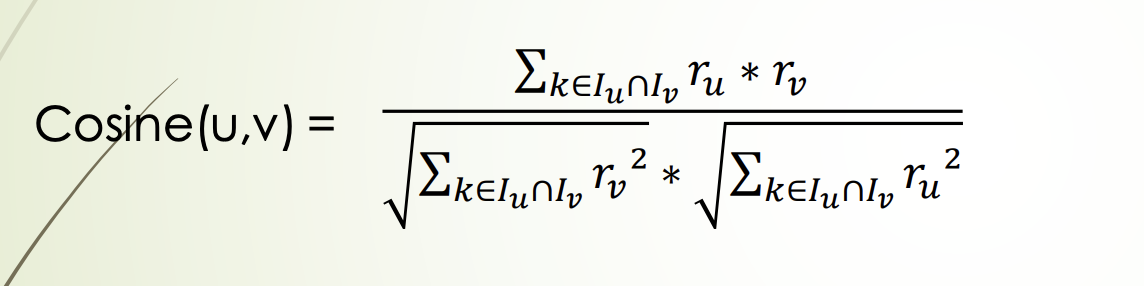

In [19]:
from sklearn.feature_extraction.text import CountVectorizer

class ContentBasedRecommender:
    def __init__(self, path_movies, path_ratings):
        """
        Initialisation du modèle de recommandation basé sur le contenu.

        :param path_movies: chemin vers le fichier contenant les informations des films
        :param path_ratings: chemin vers le fichier contenant les évaluations des utilisateurs
        """
        self.path_movies = path_movies
        self.path_ratings = path_ratings
        self.movies_df = None
        self.user_ratings_df = None

    def _prep_data(self):
        """
        Préparer les données pour le système de recommandation.
        """
        # Charger les données des films et des évaluations
        self.movies_df = pd.read_csv(self.path_movies, usecols=['movieId', 'title', 'genres'])
        self.user_ratings_df = pd.read_csv(self.path_ratings, usecols=['userId', 'movieId', 'rating'])

        # Gérer les valeurs manquantes dans les genres
        self.movies_df['genres'] = self.movies_df['genres'].fillna('')
        return self.movies_df

    def _compute_similarity_matrix(self):
        """
        Calculer manuellement la matrice de similarité cosinus basée sur les genres des films.
        """
        # Vectoriser les genres avec CountVectorizer
        count_vectorizer = CountVectorizer(tokenizer=lambda x: x.split('|'))
        genre_matrix = count_vectorizer.fit_transform(self.movies_df['genres']).toarray()

        # Initialiser la matrice de similarité
        num_movies = genre_matrix.shape[0]
        similarity_matrix = np.zeros((num_movies, num_movies))

        # Calculer manuellement la similarité cosinus
        for i in range(num_movies):
            for j in range(num_movies):
                # Produit scalaire entre les vecteurs
                dot_product = np.dot(genre_matrix[i], genre_matrix[j])
                # Normes des vecteurs
                norm_i = np.linalg.norm(genre_matrix[i])
                norm_j = np.linalg.norm(genre_matrix[j])
                # Calcul de la similarité cosinus
                similarity_matrix[i][j] = dot_product / (norm_i * norm_j) if norm_i * norm_j != 0 else 0

        return similarity_matrix

    def recommend_movies(self, user_id, n_recommendations=10):
        """
        Recommander des films non vus par l'utilisateur, basés sur le contenu.

        :param user_id: ID de l'utilisateur pour lequel les recommandations sont générées
        :param n_recommendations: nombre de films à recommander
        :return: liste des titres de films recommandés
        """
        # Préparer les données et calculer la matrice de similarité
        self._prep_data()
        similarity_matrix = self._compute_similarity_matrix()

        # Obtenir les films notés par l'utilisateur
        user_ratings = self.user_ratings_df[self.user_ratings_df['userId'] == user_id]
        user_watched_movies = user_ratings['movieId'].tolist()

        # Initialiser un tableau pour stocker les scores de similarité
        movie_scores = np.zeros(len(self.movies_df))

        # Calculer les scores pour chaque film basé sur la similarité avec les films notés par l'utilisateur
        for movie_id in user_watched_movies:
            if movie_id in self.movies_df['movieId'].values:
                movie_index = self.movies_df[self.movies_df['movieId'] == movie_id].index[0]
                movie_scores += similarity_matrix[movie_index]

        # Exclure les films déjà vus par l'utilisateur
        self.movies_df['score'] = movie_scores
        recommendations = self.movies_df[~self.movies_df['movieId'].isin(user_watched_movies)] \
            .sort_values(by='score', ascending=False) \
            .head(n_recommendations)

        return recommendations['title'].tolist()


In [20]:
# Exemple d'utilisation
if __name__ == "__main__":
    # Chemins des fichiers
    path_movies = "../movies.csv"   # Fichier contenant movieId, title, genres
    path_ratings = "../ratings.csv"  # Fichier contenant userId, movieId, rating

    # Instancier le système de recommandation
    recommender = ContentBasedRecommender(path_movies, path_ratings)

    # Recommander des films pour l'utilisateur avec l'ID 1
    user_id = 1
    recommended_movies = recommender.recommend_movies(user_id, n_recommendations=10)

    print(f"Films recommandés pour l'utilisateur {user_id} :")
    for movie in recommended_movies:
        print(movie)


Films recommandés pour l'utilisateur 1 :
Dragonheart 2: A New Beginning (2000)
Hunting Party, The (2007)
Flashback (1990)
The Great Train Robbery (1978)
Stunt Man, The (1980)
Extreme Days (2001)
Maximum Ride (2016)
Machete (2010)
Charlie's Angels: Full Throttle (2003)
After the Sunset (2004)
